# Mean reversion with bollinger bands

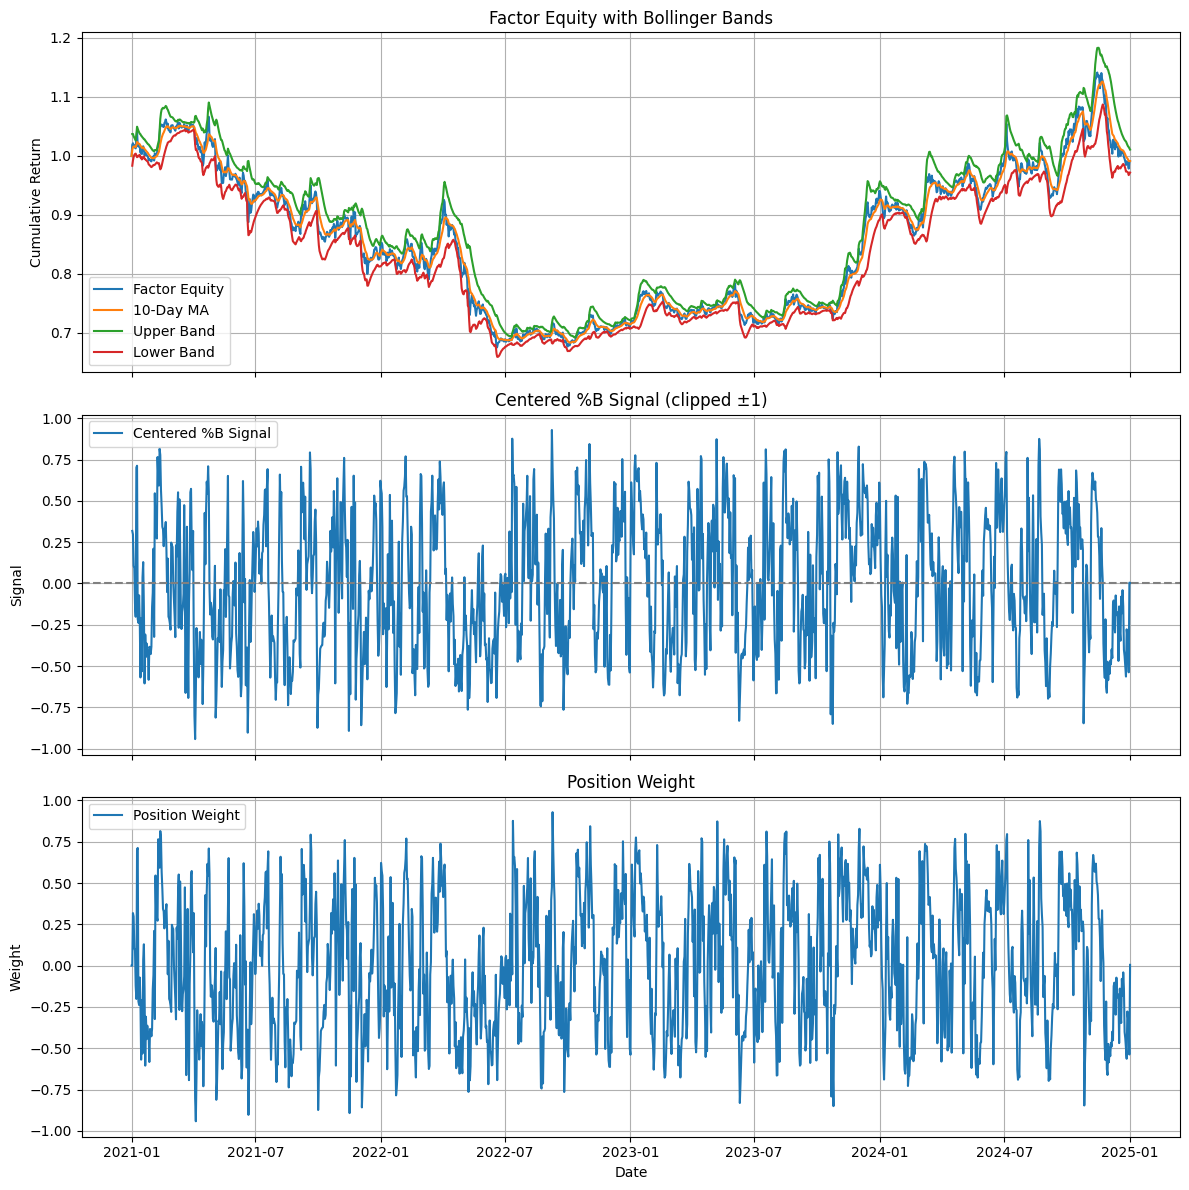

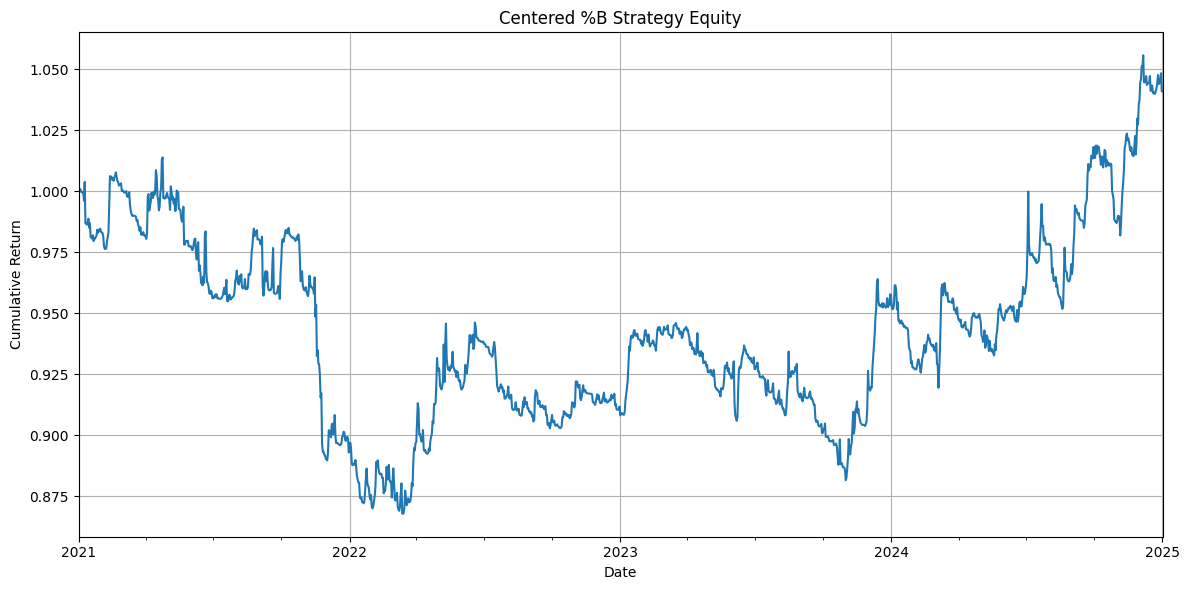

Annualized Return:   1.00%
Annualized Volatility: 7.45%
Sharpe Ratio:         0.13
Max Drawdown:         -14.40%

10‑Day Information Coefficient (IC): 0.0596


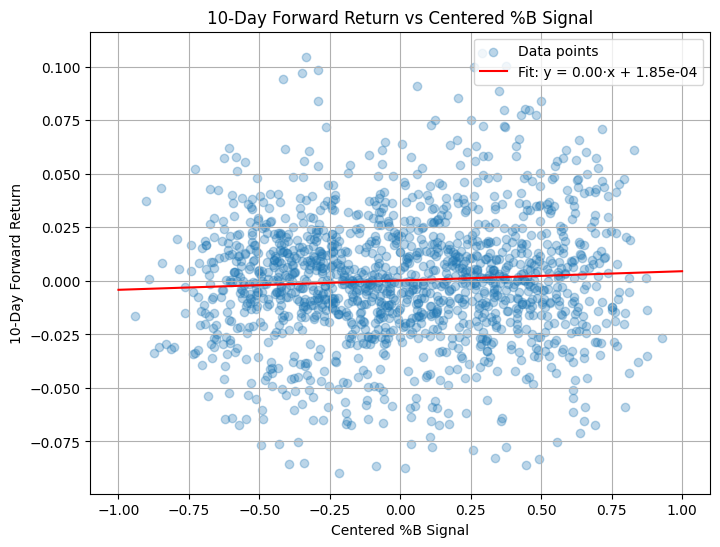

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Backtest: Centered %B Signal on Factor Returns
# + 10‑Day IC & Scatter + Linear Regression
# Period: 2021–2025‑01‑01
# ---------------------------------------

def compute_performance(ret_series):
    """
    Calculate annualized performance metrics.
    """
    n = len(ret_series)
    total_return = (1 + ret_series).prod()
    ann_return = total_return ** (365.0 / n) - 1
    ann_vol = ret_series.std() * np.sqrt(365)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    cum = (1 + ret_series).cumprod()
    peak = cum.cummax()
    drawdown = cum / peak - 1
    max_dd = drawdown.min()
    return ann_return, ann_vol, sharpe, max_dd

def main():
    # Load factor returns
    df = pd.read_csv('factor_returns.csv', parse_dates=['date'], index_col='date')
    fr = df['factor_return']

    # Filter initial zeros and restrict period
    first_valid = fr.ne(0).idxmax()
    fr = fr.loc[first_valid:'2025-01-01']
    fr = fr.loc['2021-01-01':]

    # Cumulative "price" series
    price = (1 + fr).cumprod()

    # Bollinger Bands
    window = 10
    rolling_mean = price.ewm(span=window).mean()
    rolling_std  = price.ewm(span=window).std()
    upper_band   = rolling_mean + 2 * rolling_std
    lower_band   = rolling_mean - 2 * rolling_std

    # Centered %B signal: map [0,1] → [-1,1]
    pB     = (price - lower_band) / (upper_band - lower_band)
    signal = (pB * 2 - 1).clip(-1, 1)

    # Weights proportional to signal (shifted)
    weights = signal.shift(1).fillna(0)

    # --- Plots ---
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Top: price + Bollinger Bands
    axes[0].plot(price, label='Factor Equity')
    axes[0].plot(rolling_mean, label=f'{window}-Day MA')
    axes[0].plot(upper_band, label='Upper Band')
    axes[0].plot(lower_band, label='Lower Band')
    axes[0].set_title('Factor Equity with Bollinger Bands')
    axes[0].set_ylabel('Cumulative Return')
    axes[0].legend()
    axes[0].grid(True)

    # Middle: centered %B signal
    axes[1].plot(signal, label='Centered %B Signal')
    axes[1].axhline(0, color='gray', linestyle='--')
    axes[1].set_title('Centered %B Signal (clipped ±1)')
    axes[1].set_ylabel('Signal')
    axes[1].legend()
    axes[1].grid(True)

    # Bottom: position weight
    axes[2].plot(weights, label='Position Weight')
    axes[2].set_title('Position Weight')
    axes[2].set_ylabel('Weight')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Strategy returns & equity
    strat_ret = weights * fr
    cum_strat = (1 + strat_ret).cumprod()
    plt.figure(figsize=(12, 6))
    cum_strat.plot()
    plt.title('Centered %B Strategy Equity')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Performance statistics
    ann_ret, ann_vol, sharpe, max_dd = compute_performance(strat_ret.dropna())
    print(f"Annualized Return:   {ann_ret:.2%}")
    print(f"Annualized Volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio:         {sharpe:.2f}")
    print(f"Max Drawdown:         {max_dd:.2%}")

    # ----- 10‑Day IC and Scatter + Linear Regression -----
    # 1) compute 10-day forward returns
    fwd_ret = price.shift(-10) / price - 1

    # 2) align signal & forward returns
    df_ic = pd.DataFrame({
        'signal': signal,
        'fwd_ret': fwd_ret
    }).dropna()

    # 3) Information Coefficient (Pearson correlation)
    ic = df_ic['signal'].corr(df_ic['fwd_ret'])
    print(f"\n10‑Day Information Coefficient (IC): {ic:.4f}")

    # 4) linear fit y = m*x + b
    m, b = np.polyfit(df_ic['signal'], df_ic['fwd_ret'], 1)

    # 5) scatter + regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(df_ic['signal'], df_ic['fwd_ret'],
                alpha=0.3, label='Data points')
    x_vals = np.linspace(-1, 1, 100)
    plt.plot(x_vals, m * x_vals + b, color='red',
             label=f'Fit: y = {m:.2f}·x + {b:.2e}')
    plt.title('10‑Day Forward Return vs Centered %B Signal')
    plt.xlabel('Centered %B Signal')
    plt.ylabel('10‑Day Forward Return')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


# Trend backtest


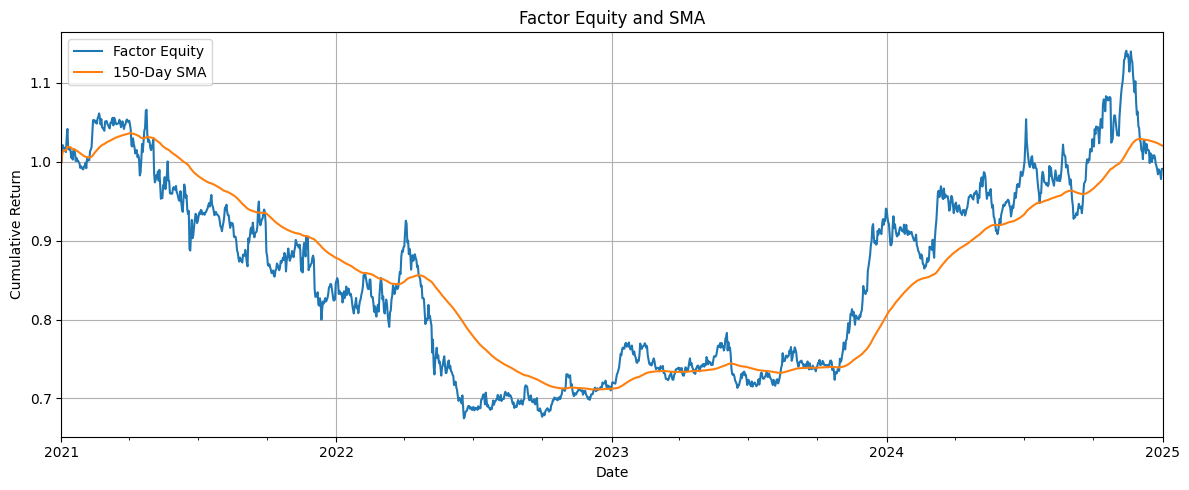

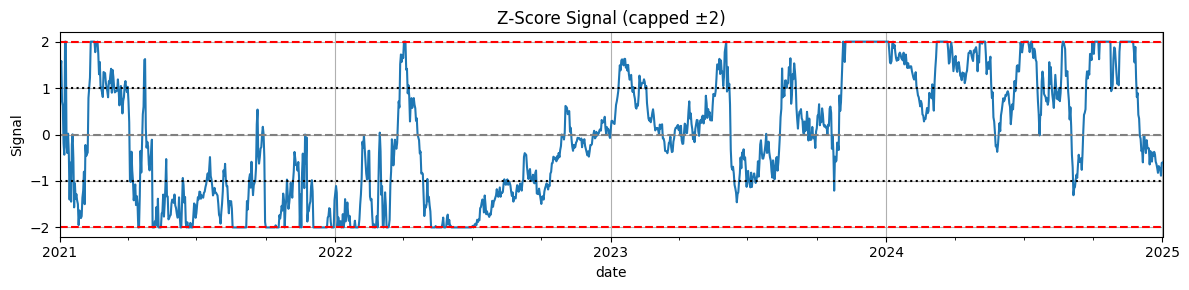

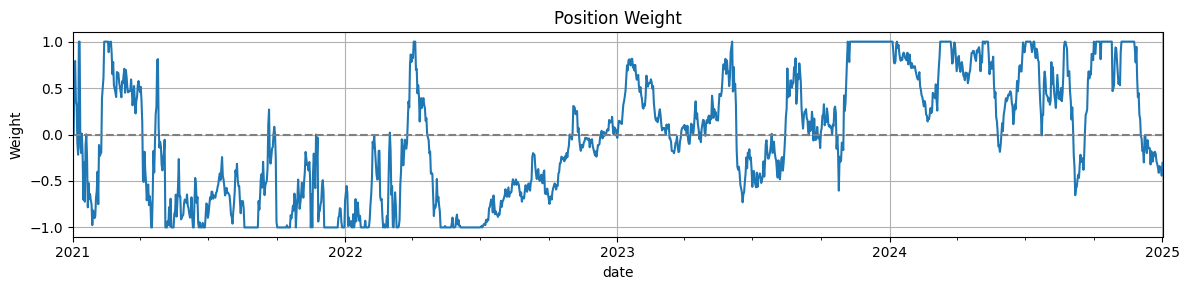

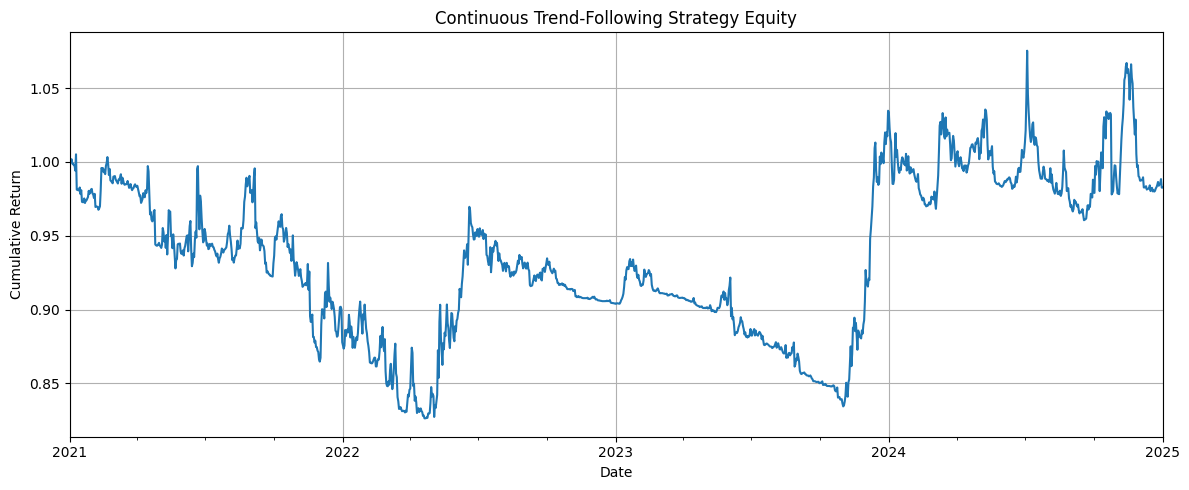

Annualized Return:     -0.30%
Annualized Volatility: 10.85%
Sharpe Ratio:          -0.03
Max Drawdown:          -17.80%


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Backtest: Continuous SMA Trend-Following
# Period: 2021–2025-01-01
# ---------------------------------------

def compute_performance(ret_series):
    """
    Calculate annualized performance metrics.
    """
    n = len(ret_series)
    total_return = (1 + ret_series).prod()
    ann_return = total_return ** (252.0 / n) - 1
    ann_vol = ret_series.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    cum = (1 + ret_series).cumprod()
    peak = cum.cummax()
    drawdown = cum / peak - 1
    max_dd = drawdown.min()
    return ann_return, ann_vol, sharpe, max_dd


def main():
    # Load factor returns
    df = pd.read_csv('factor_returns.csv', parse_dates=['date'], index_col='date')
    fr = df['factor_return']

    # Filter initial zeros and restrict period
    first_valid = fr.ne(0).idxmax()
    fr = fr.loc[first_valid:'2025-01-01']
    fr = fr.loc['2021-01-01':]

    # Build cumulative "price"
    price = (1 + fr).cumprod()

    # --- Parameters ---
    sma_window = 150

    # Compute SMA and residual
    sma = price.ewm(span=sma_window).mean()
    resid = price - sma

    # Rolling std of the residual over same window
    sigma = resid.ewm(span=sma_window).std()

    # Continuous z‑score signal, capped at ±2
    signal = (resid / sigma).clip(-2.0, 2.0)

    # Scale into weights: ±2 → ±1, linearly
    weights = (signal / 2.0).shift(1).fillna(0)

    # --- Plots ---
    # 1) Price & SMA
    plt.figure(figsize=(12, 5))
    price.plot(label='Factor Equity')
    sma.plot(label=f'{sma_window}-Day SMA')
    plt.title('Factor Equity and SMA')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2) Signal
    plt.figure(figsize=(12, 3))
    signal.plot(title='Z‑Score Signal (capped ±2)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axhline(1, color='black', linestyle=':')
    plt.axhline(-1, color='black', linestyle=':')
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='red', linestyle='--')
    plt.ylabel('Signal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3) Weights
    plt.figure(figsize=(12, 3))
    weights.plot(title='Position Weight')
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Strategy returns & equity ---
    strat_ret = weights * fr
    cum_strat = (1 + strat_ret).cumprod()

    plt.figure(figsize=(12, 5))
    cum_strat.plot()
    plt.title('Continuous Trend‑Following Strategy Equity')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Performance statistics
    ann_ret, ann_vol, sharpe, max_dd = compute_performance(strat_ret.dropna())
    print(f"Annualized Return:     {ann_ret:.2%}")
    print(f"Annualized Volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio:          {sharpe:.2f}")
    print(f"Max Drawdown:          {max_dd:.2%}")


if __name__ == '__main__':
    main()
